# CAM team photo


This notebook is based on code found at: 

https://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html.html


In [29]:
%matplotlib inline

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform

Import image that we want to classify. Based on code from SML course UU - lab exercise

RGB image of size (2560, 1440)


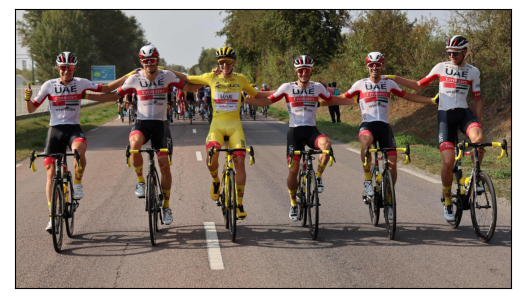

In [30]:
from urllib.request import urlopen
from urllib.error import URLError
import matplotlib.pyplot as plt

#image_url = 'https://github.com/Falk0/latex_master1_semester2/blob/main/deep_learning_for_image_analysis/figures/assignment_4/team_1.png?raw=true'
image_url = 'https://imgresizer.eurosport.com/unsafe/2560x0/filters:format(jpeg)/origin-imgresizer.eurosport.com/2022/06/27/3399674-69473648-2560-1440.jpg'

try:
    with Image.open(urlopen(image_url)) as im:
        # The following fixes some problems when loading images:
        # https://stackoverflow.com/a/64598016
        image = im.convert("RGB")
except (URLError, OSError):
    print("please provide a valid URL or local path")
else:    
    print(f"{image.mode} image of size {image.size}")
    plt.imshow(np.asarray(image))
    plt.xticks([])
    plt.yticks([])
    plt.show()

Preprocess image

In [31]:
# Imagenet mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

### Import class names

In [32]:
# Store class names in a dictionary
# Define the URL of the raw text file on GitHub
class_name = {}

# Define the URL of the raw text file on GitHub
url = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'

try:
    # Open the URL and read the contents of the file
    with urlopen(url) as response:
        text = response.read().decode('utf-8')
        # remove {} from text
        text = text.replace('{', '')
        for line in text.splitlines():
            key, value = line.split(':')
            key = int(key)
            # if value has more than two , isert \n  at the third ,
            if value.count(',') >= 2:
                value = value.replace(',', '\n', 1)
            # remove last , if present
            if value.endswith(','):
                value = value[:-1]

            class_name[key] = value.replace("'", "")

except URLError as e:
    print("please provide a valid URL or local path")


In [33]:
tensor = preprocess(image)

In [34]:
prediction_var = Variable((tensor.unsqueeze(0)), requires_grad=True)

## Load pre-trained model

In [35]:
model = models.resnet18(pretrained=True)

c:\Users\Brukare\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Brukare\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
model.eval();

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [38]:
final_layer = model._modules.get('layer4')

In [39]:
activated_features = SaveFeatures(final_layer)

In [40]:
prediction = model(prediction_var)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()

C:\Users\Brukare\AppData\Local\Temp\ipykernel_5188\3865586587.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities = F.softmax(prediction).data.squeeze()


In [41]:
topk(pred_probabilities,1)

torch.return_types.topk(
values=tensor([0.8849]),
indices=tensor([880]))

In [42]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]


In [43]:
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [44]:
weight_softmax_params

[Parameter containing:
 tensor([[-0.0185, -0.0705, -0.0518,  ..., -0.0390,  0.1735, -0.0410],
         [-0.0818, -0.0944,  0.0174,  ...,  0.2028, -0.0248,  0.0372],
         [-0.0332, -0.0566, -0.0242,  ..., -0.0344, -0.0227,  0.0197],
         ...,
         [-0.0103,  0.0033, -0.0359,  ..., -0.0279, -0.0115,  0.0128],
         [-0.0359, -0.0353, -0.0296,  ..., -0.0330, -0.0110, -0.0513],
         [ 0.0021, -0.0248, -0.0829,  ...,  0.0417, -0.0500,  0.0663]],
        requires_grad=True),
 Parameter containing:
 tensor([-2.6341e-03,  3.0005e-03,  6.5581e-04, -2.6909e-02,  6.3637e-03,
          1.3260e-02, -1.1178e-02,  2.0639e-02, -3.6373e-03, -1.2325e-02,
         -1.2629e-02, -7.2057e-03, -1.9321e-02, -2.4960e-02, -1.1885e-02,
         -8.3259e-03, -9.5745e-03, -1.6658e-02,  9.1804e-03, -1.5354e-02,
          7.1358e-03,  3.0737e-02,  1.3239e-02, -7.7528e-03,  4.7448e-03,
          1.1175e-02,  1.5949e-02, -1.6712e-02, -1.0130e-03, -3.7167e-03,
          6.5269e-03, -1.2041e-02,  9.04

In [45]:
class_idx = topk(pred_probabilities,1)[1].int()
print(class_idx, class_name[class_idx[0].item()])

tensor([880], dtype=torch.int32)  unicycle
 monocycle


## Prediction

https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

Animal team: 354: 'Arabian camel, dromedary, Camelus dromedarius'

TdF team: 880: 'unicycle, monocycle'

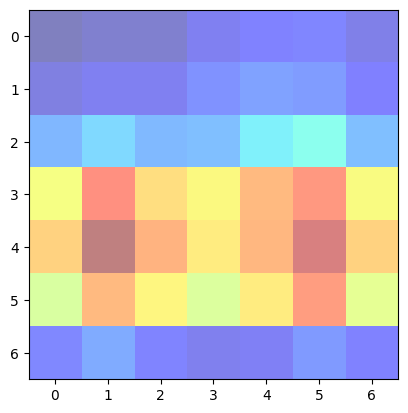

In [46]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx )
imshow(overlay[0], alpha=0.5, cmap='jet')

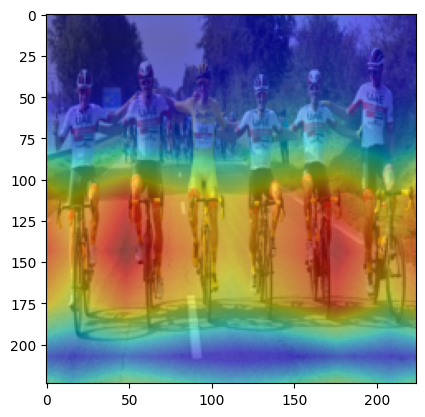

In [47]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');

## Prediction second choice

Picking the second best prediction

Animal team: 643: 'mask'

TdF team 439: 'bearskin, busby, shako',

In [48]:
class_idx = topk(pred_probabilities,2)[1].int()
class_idx

tensor([880, 439], dtype=torch.int32)

In [49]:
overlay = getCAM(activated_features.features, weight_softmax, 439 )

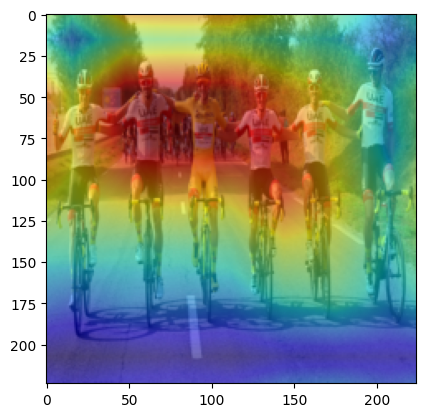

In [50]:
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');
